# Test Subset
___

In [1]:
clustering_strategy = 'MiniBatchKMeans'

## Setup

### Importing Packages

In [2]:
import os
import shutil
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from astronomaly.dimensionality_reduction import pca
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.float_format", "{:.2e}".format)

### Directories

In [ ]:
# Data Root Directory
data_root_dir = os.path.join(os.getcwd(), 'Data')

# Label Directory
label_dir = os.path.join(data_root_dir, 'DeCaLs/gz_decals_volunteers_1_and_2.parquet')

# Image Directory
img_dir = os.path.join(data_root_dir, 'DeCaLs')

# Feature Directory
feature_dir = os.path.join(data_root_dir, 'features.parquet')

# Cluster Assignment Directory
clusters_dir = os.path.join(data_root_dir, f'{clustering_strategy}_clusters_with_prob.parquet')

# Test Subset Directory
test_subset_dir = os.path.join(data_root_dir, f'{clustering_strategy}_test_subset.parquet') 

# Classification Directories
output_root_dir = os.path.join(data_root_dir, 'Output')
spiral_dir = os.path.join(output_root_dir, 'spirals')
round_ell_dir = os.path.join(output_root_dir, 'round_ellipticals')
edge_on_dir = os.path.join(output_root_dir, 'edge_on')

### Cluster Probabilities

In [4]:
clusters = pd.read_parquet(clusters_dir)
print('Cluster Assignment: ', clusters.shape)

Cluster Assignment:  (230575, 21)


### Features

In [5]:
features = pd.read_parquet(feature_dir)
print('Features: ', features.shape)

Features:  (230575, 512)


In [6]:
feat_clust = pd.concat([clusters, features], axis=1)
print('Cluster Assignment and Features: ', feat_clust.shape)

Cluster Assignment and Features:  (230575, 533)


### Volunteer Labels

In [7]:
volunteer_labels = pd.read_parquet(label_dir)
volunteer_labels = volunteer_labels.set_index('iauname')
print('Volunteer Labels: ', volunteer_labels.shape)

Volunteer Labels:  (92960, 114)


### Filtering

In [8]:
common_labels = volunteer_labels.index.intersection(feat_clust.index)
filtered_volunteer_labels = volunteer_labels.loc[common_labels]
filtered_volunteer_labels.index.name= 'iauname'
filtered_feat_clust = feat_clust.loc[common_labels]
filtered_data = pd.concat([filtered_feat_clust, filtered_volunteer_labels], axis=1)
print('Filtered Cluster Assignment and Features: ', filtered_feat_clust.shape)
print('Filtered Volunteer Labels: ', filtered_volunteer_labels.shape)
print('Filtered Data: ', filtered_data.shape)

Filtered Cluster Assignment and Features:  (65290, 533)
Filtered Volunteer Labels:  (65290, 114)
Filtered Data:  (65290, 647)


## Galaxy Assignment

In [9]:
count = 0
filenames_to_find = set(filtered_volunteer_labels.index.astype(str) + '.png')

for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file in filenames_to_find:
            count +=1
print('No. of labelled images: ', count)

No. of labelled images:  65290


In [10]:
columns = [col for col in filtered_volunteer_labels.columns if 'has-spiral' in col]
for col in columns:
    print(col)

has-spiral-arms_total-votes
has-spiral-arms_yes
has-spiral-arms_yes_fraction
has-spiral-arms_yes_debiased
has-spiral-arms_no
has-spiral-arms_no_fraction
has-spiral-arms_no_debiased


### Fixing fraction and totals

In [11]:
filtered_data['disk-edge-on_manual-total'] =   (filtered_data['disk-edge-on_yes'] 
                                                    + filtered_data['disk-edge-on_no'])
filtered_data['disk-edge-on_yes_manual-fraction'] = filtered_data['disk-edge-on_yes'] / filtered_data['disk-edge-on_manual-total']
filtered_data['disk-edge-on_no_manual-fraction'] = filtered_data['disk-edge-on_no'] / filtered_data['disk-edge-on_manual-total']

filtered_data['merging_manual-total'] =   (filtered_data['merging_merger'] 
                                               + filtered_data['merging_tidal-debris'] 
                                               + filtered_data['merging_both'] 
                                               + filtered_data['merging_neither'])
filtered_data['merging_merger_manual-fraction'] = filtered_data['merging_merger'] / filtered_data['merging_manual-total']
filtered_data['merging_tidal-debris_manual-fraction'] = filtered_data['merging_tidal-debris'] / filtered_data['merging_manual-total']
filtered_data['merging_both_manual-fraction'] = filtered_data['merging_both'] / filtered_data['merging_manual-total']
filtered_data['merging_neither_manual-fraction'] = filtered_data['merging_neither'] / filtered_data['merging_manual-total']

filtered_data['smooth-or-featured_manual-total'] =   (filtered_data['smooth-or-featured_smooth'] 
                                                          + filtered_data['smooth-or-featured_featured-or-disk'] 
                                                          + filtered_data['smooth-or-featured_artifact'])
filtered_data['smooth-or-featured_smooth_manual-fraction'] = filtered_data['smooth-or-featured_smooth'] / filtered_data['smooth-or-featured_manual-total']
filtered_data['smooth-or-featured_featured-or-disk_manual-fraction'] = filtered_data['smooth-or-featured_featured-or-disk'] / filtered_data['smooth-or-featured_manual-total']
filtered_data['smooth-or-featured_artifact_manual-fraction'] = filtered_data['smooth-or-featured_artifact'] / filtered_data['smooth-or-featured_manual-total']

filtered_data['how-rounded_manual-total'] =   (filtered_data['how-rounded_completely'] 
                                                   + filtered_data['how-rounded_in-between'] 
                                                   + filtered_data['how-rounded_cigar-shaped'])
filtered_data['how-rounded_completely_manual-fraction'] = filtered_data['how-rounded_completely'] / filtered_data['how-rounded_manual-total']
filtered_data['how-rounded_in-between_manual-fraction'] = filtered_data['how-rounded_in-between'] / filtered_data['how-rounded_manual-total']
filtered_data['how-rounded_cigar-shaped_manual-fraction'] = filtered_data['how-rounded_cigar-shaped'] / filtered_data['how-rounded_manual-total']

filtered_data['has-spiral-arms_manual-total'] =   (filtered_data['has-spiral-arms_yes'] 
                                                       + filtered_data['has-spiral-arms_no'])
filtered_data['has-spiral-arms_yes_manual-fraction'] = filtered_data['has-spiral-arms_yes'] / filtered_data['has-spiral-arms_manual-total']
filtered_data['has-spiral-arms_no_manual-fraction'] = filtered_data['has-spiral-arms_no'] / filtered_data['has-spiral-arms_manual-total']

### Edge-on Galaxies

In [12]:
edge_on_gal = filtered_data[((filtered_data['disk-edge-on_manual-total']) >= 5) &
                                   (filtered_data['disk-edge-on_yes_manual-fraction'] > 0.8) &
                                   (filtered_data['merging_manual-total'] >= 10) &
                                   (filtered_data['merging_merger_manual-fraction'] < 0.2)].copy()
edge_on_gal['Type'] = 'E'

In [13]:
filenames_to_find = set(edge_on_gal.index.astype(str) + '.png')
count = 0

for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file in filenames_to_find:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(edge_on_dir, file)
            #shutil.copy2(src_path, dest_path)
            count += 1

print(count)

5421


### Round Elliptical Galaxies

In [14]:
round_ell_gal = filtered_data[(filtered_data['smooth-or-featured_smooth_manual-fraction'] > 0.8) &
                                    (filtered_data['how-rounded_manual-total'] >= 5) &
                                    (filtered_data['how-rounded_completely_manual-fraction'] > 0.8) &
                                    (filtered_data['merging_manual-total'] >= 10) &
                                    (filtered_data['merging_merger_manual-fraction'] < 0.2)].copy()
round_ell_gal['Type'] = 'R'

In [15]:
filenames_to_find = set(round_ell_gal.index.astype(str) + '.png')
count = 0

for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file in filenames_to_find:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(round_ell_dir, file)
            #shutil.copy2(src_path, dest_path)
            count += 1

print(count)

4231


### Spiral Galaxies

In [16]:
spiral_gal = filtered_data[(filtered_data['smooth-or-featured_featured-or-disk_manual-fraction'] > 0.8) &
                                 (filtered_data['has-spiral-arms_manual-total'] >= 5) &
                                 (filtered_data['has-spiral-arms_yes_manual-fraction'] > 0.8) &
                                 (filtered_data['merging_manual-total'] >= 10) &
                                 (filtered_data['merging_merger_manual-fraction'] < 0.2)].copy()
spiral_gal['Type'] = 'S'

In [17]:
filenames_to_find = set(spiral_gal.index.astype(str) + '.png')
count = 0

for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file in filenames_to_find:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(spiral_dir, file)
            #shutil.copy2(src_path, dest_path)
            count += 1

print(count)

4034


In [18]:
# save cluster index to label dataframe
test_subset = pd.concat([spiral_gal, round_ell_gal, edge_on_gal])
print('Test Subset: ', test_subset.shape)

Test Subset:  (13686, 667)


### Plotting

<Axes: xlabel='Cluster', ylabel='smooth-or-featured_featured-or-disk_fraction'>

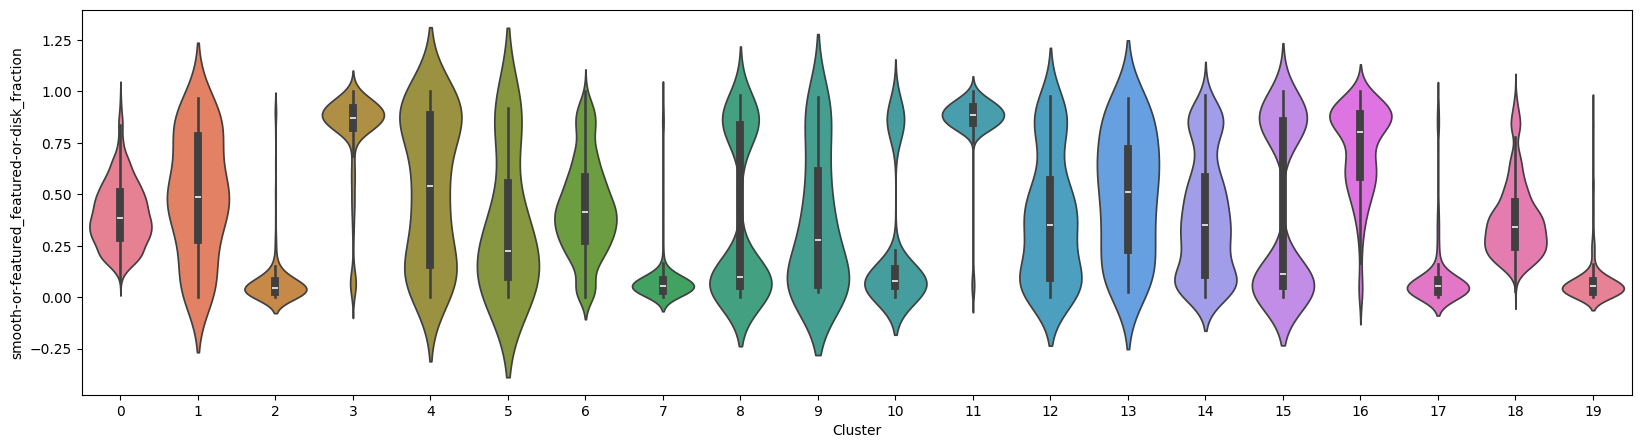

In [19]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='smooth-or-featured_featured-or-disk_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='how-rounded_cigar-shaped_fraction'>

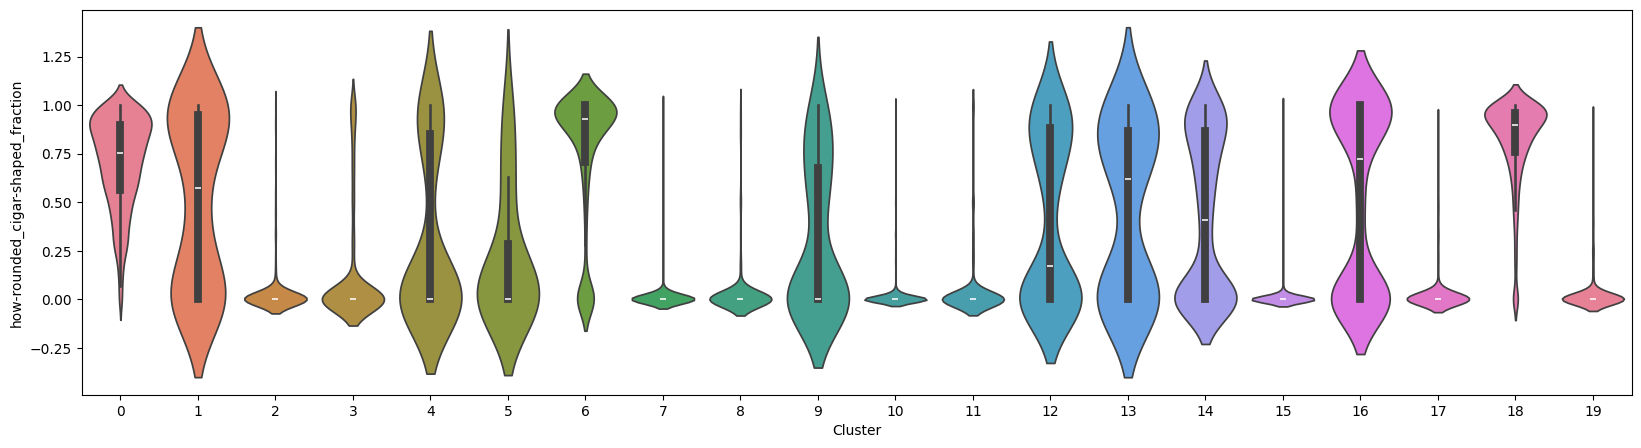

In [20]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='how-rounded_cigar-shaped_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='disk-edge-on_yes_fraction'>

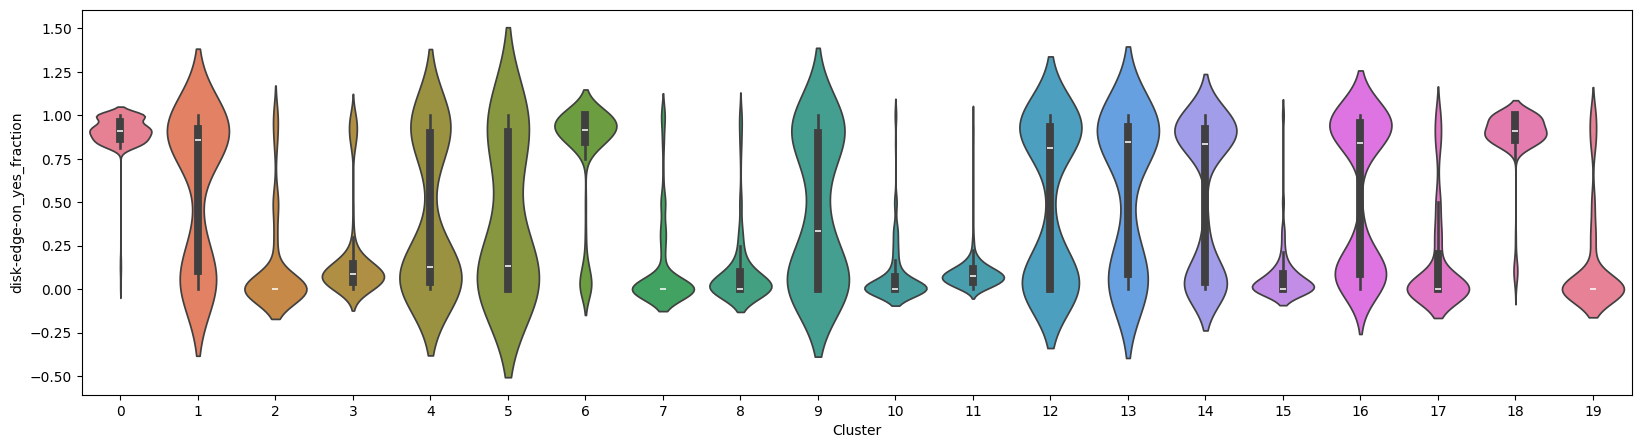

In [21]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='disk-edge-on_yes_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='bulge-size_dominant_fraction'>

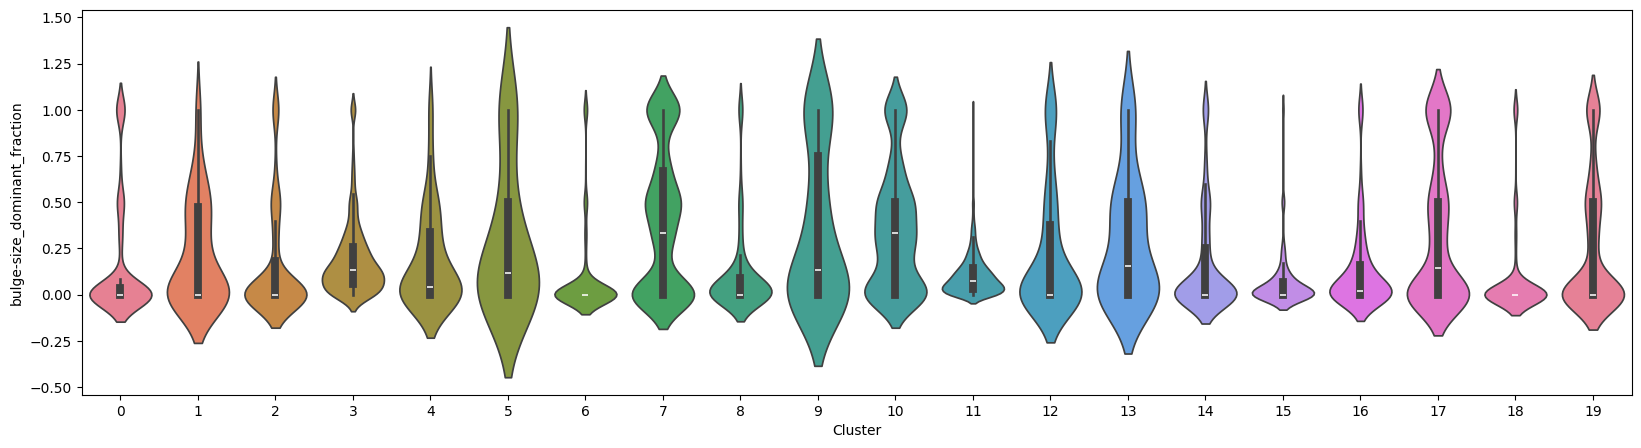

In [22]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='bulge-size_dominant_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

<Axes: xlabel='Cluster', ylabel='merging_neither_fraction'>

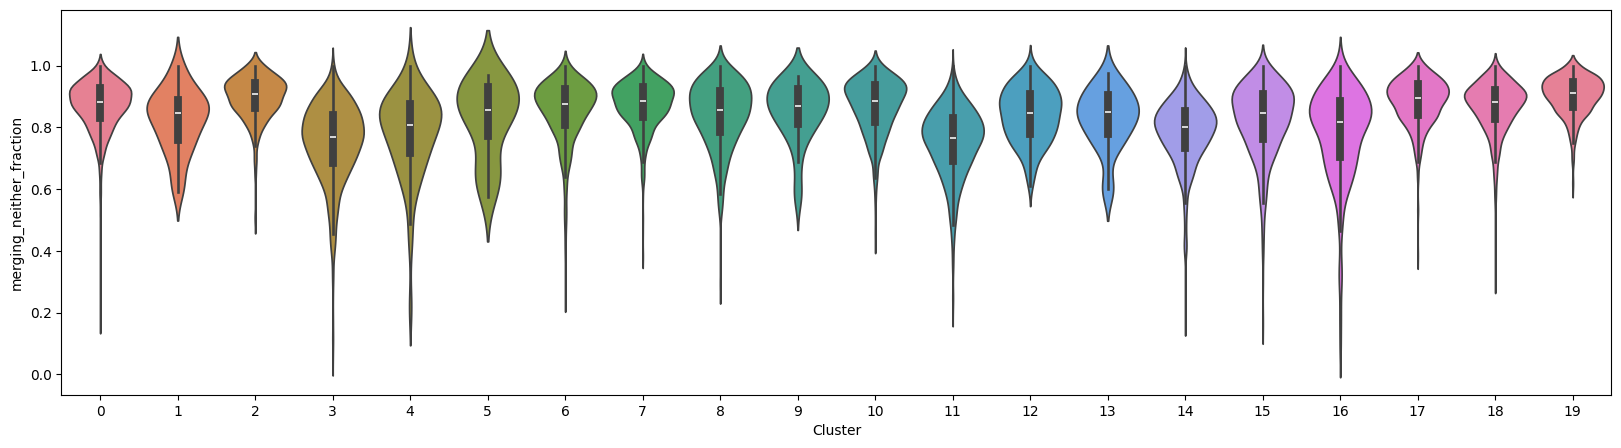

In [23]:
plt.figure(figsize=(20,5))
sns.violinplot(x='Cluster', y='merging_neither_fraction', data=test_subset, density_norm='width', palette='husl', hue='Cluster', legend = False)

## Cluster Assignment

In [24]:
counts = test_subset.groupby(['Cluster', 'Type']).size()
counts_df = counts.reset_index(name='Count')
counts_df['Total'] = counts_df.groupby('Cluster')['Count'].transform('sum')
counts_df['Percentage'] = counts_df['Count'] / counts_df['Total'] * 100
dominant = counts_df.loc[counts_df.groupby('Cluster')['Count'].idxmax()]

cluster_df = dominant.set_index('Cluster')[['Type', 'Percentage']]
cluster_df.columns = ['Dominant_Type', 'Percentage']
cluster_df['Percentage'] = cluster_df['Percentage'].round(2)

print(cluster_df)

        Dominant_Type  Percentage
Cluster                          
0                   E    9.86e+01
1                   E    6.20e+01
2                   R    9.26e+01
3                   S    8.22e+01
4                   E    3.75e+01
5                   E    3.75e+01
6                   E    8.28e+01
7                   R    9.45e+01
8                   R    6.06e+01
9                   R    4.38e+01
10                  R    7.72e+01
11                  S    9.55e+01
12                  E    4.96e+01
13                  E    5.68e+01
14                  E    5.56e+01
15                  R    5.56e+01
16                  E    5.28e+01
17                  R    8.97e+01
18                  E    9.47e+01
19                  R    9.04e+01


### Fixing MiniBatchKMeans Probabilities

In [25]:
if clustering_strategy == 'MiniBatchKMeans':
    dist_columns = ['Prob_0', 'Prob_1', 'Prob_2', 'Prob_3', 'Prob_4', 'Prob_5', 'Prob_6', 'Prob_7', 'Prob_8', 'Prob_9', 'Prob_10', 
                    'Prob_11', 'Prob_12', 'Prob_13', 'Prob_14', 'Prob_15', 'Prob_16', 'Prob_17', 'Prob_18', 'Prob_19']
    
    # Smaller Distance = Big Score (dist = 100 -> score = -100) 
    scores = -test_subset[dist_columns].values 
    # Normalize scores to probabilities
    exp_scores = np.exp(scores - scores.max(axis=1, keepdims=True))
    # Softmax Probabilities
    probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)

    test_subset[dist_columns] = probs

test_subset.to_parquet(test_subset_dir)